In [1]:
from datetime import datetime, timezone, timedelta
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from helpers import util
import os

In [2]:
today = datetime.now(timezone.utc).replace(tzinfo=None)
today

datetime.datetime(2025, 11, 14, 16, 41, 56, 24051)

In [3]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
sensors_str = secrets.get_secret("SENSORS_JSON").value
sensors_data = json.loads(sensors_str)

2025-11-14 17:41:56,056 INFO: Initializing external client
2025-11-14 17:41:56,060 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-14 17:41:56,692 WARNING: UserWarning: The installed hopsworks client version 4.1.4 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-14 17:41:57,583 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272014


In [4]:
mr = project.get_model_registry()

retrieved_model_base = mr.get_model(
    name="air_quality_xgboost_base_model",
    version=1,
)
retrieved_model_lagged = mr.get_model(
    name="air_quality_xgboost_lagged_model",
    version=1,
)

# Download the saved models artifacts to a local directory
saved_model_dir_base = retrieved_model_base.download()
saved_model_dir_lagged = retrieved_model_lagged.download()

In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model_base = XGBRegressor()
retrieved_xgboost_model_base.load_model(saved_model_dir_base + "/model.json")
retrieved_xgboost_model_lagged = XGBRegressor()
retrieved_xgboost_model_lagged.load_model(saved_model_dir_lagged + "/model.json")

In [6]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

yesterday_2359 = (today - timedelta(days=1)).replace(hour=23, minute=59, second=59, microsecond=0)
air_quality_data = air_quality_fg.filter(air_quality_fg.date >= yesterday_2359.date()).read().drop(columns="url")
weather_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by='date')

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 


In [7]:
weather_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-15 00:00:00+00:00,2.10,0.0,8.669949,221.633453,skoghall
2,2025-11-15 00:00:00+00:00,1.25,0.0,9.585739,235.713074,jonsbyn
3,2025-11-15 00:00:00+00:00,1.35,0.0,12.738099,227.290634,årjäng
4,2025-11-15 00:00:00+00:00,0.75,0.0,10.883676,235.784241,nykroppa
1,2025-11-16 00:00:00+00:00,3.30,0.0,7.920000,270.000000,årjäng
5,2025-11-16 00:00:00+00:00,3.55,0.0,4.198285,239.036301,skoghall
6,2025-11-16 00:00:00+00:00,2.40,0.0,4.693826,237.528824,jonsbyn
7,2025-11-16 00:00:00+00:00,2.30,0.0,6.924738,242.102829,nykroppa
10,2025-11-17 00:00:00+00:00,0.95,0.0,5.014219,291.037567,skoghall
11,2025-11-17 00:00:00+00:00,0.10,0.0,6.214563,280.007904,nykroppa


In [8]:
air_quality_data

,date,pm25,lagged_1,lagged_2,lagged_3,country,city,street
0,2025-11-14 00:00:00+00:00,4.0,5.0,33.978001,10.500,sweden,skoghall,folkungavägen
1,2025-11-14 00:00:00+00:00,1.0,6.0,4.620000,3.528,sweden,jonsbyn,acksjön
2,2025-11-14 00:00:00+00:00,6.0,7.0,24.444000,7.686,sweden,nykroppa,timmersvägen
3,2025-11-14 00:00:00+00:00,2.0,3.0,14.700000,10.920,sweden,årjäng,strand


In [9]:
def prepare_prediction_row(row, air_quality_data, lagged_available):
    # Ensure air_quality_data['date'] is datetime
    air_quality_data['date'] = pd.to_datetime(air_quality_data['date'])
    
    # Initialize dictionary for features
    features = {}
    city = row['city']
    pred_date = pd.to_datetime(row['date'])
    prev_date = pred_date - pd.Timedelta(days=1)

    # filter the air quality data
    last_days_aq = air_quality_data[
        (air_quality_data['city'] == city) &
        (air_quality_data['date'].dt.date == prev_date.date())
    ]

    if lagged_available:
        features['lagged_3'] = last_days_aq['lagged_2'].item()
        features['lagged_2'] = last_days_aq['lagged_1'].item()
        features['lagged_1'] = last_days_aq['predicted_pm25'].item()
    features['city'] = city
    features['street'] = last_days_aq['street'].item()
    features['country'] = last_days_aq['country'].item()
    features['date'] = pred_date
    
    # Copy weather features
    weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
    for col in weather_cols:
        features[col] = row[col]
    
    # Convert to single-row DataFrame
    prediction_df = pd.DataFrame([features])
    prediction_df['city'] = prediction_df['city'].astype('category')
    
    return prediction_df

In [10]:
def append_predicted_pm25(air_quality_data, prediction_row, predicted_pm25, lagged_available):
    new_row = prediction_row
    new_row["predicted_pm25"] = predicted_pm25
    if lagged_available:
        new_row['lagged_1'] = prediction_row['lagged_1']
        new_row['lagged_2'] = prediction_row['lagged_2']
        new_row['lagged_3'] = prediction_row['lagged_3']
    
    # Append new row to DataFrame
    updated_air_quality_data = pd.concat([air_quality_data, pd.DataFrame(new_row)], ignore_index=True)
    return updated_air_quality_data

In [11]:
air_quality_forecast_base = air_quality_data.copy().drop(columns=['lagged_1', 'lagged_2', 'lagged_3']).rename(columns={"pm25": "predicted_pm25"})
air_quality_forecast_lagged = air_quality_data.copy().rename(columns={"pm25": "predicted_pm25"})

for _, prediction in weather_data.iterrows():
    pred_date = pd.to_datetime(prediction['date'])
    prediction_df_base = prepare_prediction_row(prediction, air_quality_forecast_base, lagged_available=False)
    prediction_df_lagged = prepare_prediction_row(prediction, air_quality_forecast_lagged, lagged_available=True)
    predicted_pm25_base = retrieved_xgboost_model_base.predict(prediction_df_base[['city', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    predicted_pm25_lagged = retrieved_xgboost_model_lagged.predict(prediction_df_lagged[['lagged_1', 'lagged_2', 'lagged_3', 'city', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    air_quality_forecast_base = append_predicted_pm25(air_quality_forecast_base, prediction_df_base, predicted_pm25_base, lagged_available=False)
    air_quality_forecast_lagged = append_predicted_pm25(air_quality_forecast_lagged, prediction_df_lagged, predicted_pm25_lagged, lagged_available=True)

In [12]:
weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
air_quality_forecast_base[weather_cols] = air_quality_forecast_base[weather_cols].astype('float32')
air_quality_forecast_base["date"] = pd.to_datetime(air_quality_forecast_base["date"]).dt.tz_convert(None)
air_quality_forecast_base['days_before_forecast_day'] = (air_quality_forecast_base["date"] - pd.Timestamp(today).normalize()).dt.days
air_quality_forecast_base = air_quality_forecast_base[air_quality_forecast_base['days_before_forecast_day'] > 0]
air_quality_forecast_base

,date,predicted_pm25,country,city,street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,days_before_forecast_day
4,2025-11-15,23.409967,sweden,skoghall,folkungavägen,2.10,0.0,8.669949,221.633453,1
5,2025-11-15,22.146420,sweden,jonsbyn,acksjön,1.25,0.0,9.585739,235.713074,1
6,2025-11-15,15.236937,sweden,årjäng,strand,1.35,0.0,12.738099,227.290634,1
7,2025-11-15,19.271547,sweden,nykroppa,timmersvägen,0.75,0.0,10.883676,235.784241,1
8,2025-11-16,7.478670,sweden,årjäng,strand,3.30,0.0,7.920000,270.000000,2
9,2025-11-16,12.080351,sweden,skoghall,folkungavägen,3.55,0.0,4.198285,239.036301,2
10,2025-11-16,21.984821,sweden,jonsbyn,acksjön,2.40,0.0,4.693826,237.528824,2
11,2025-11-16,18.037535,sweden,nykroppa,timmersvägen,2.30,0.0,6.924738,242.102829,2
12,2025-11-17,20.606663,sweden,skoghall,folkungavägen,0.95,0.0,5.014219,291.037567,3
13,2025-11-17,17.840954,sweden,nykroppa,timmersvägen,0.10,0.0,6.214563,280.007904,3


In [13]:
weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
air_quality_forecast_lagged[weather_cols] = air_quality_forecast_base[weather_cols].astype('float32')
air_quality_forecast_lagged["date"] = pd.to_datetime(air_quality_forecast_lagged["date"]).dt.tz_convert(None)
air_quality_forecast_lagged['days_before_forecast_day'] = (air_quality_forecast_lagged["date"] - pd.Timestamp(today).normalize()).dt.days
air_quality_forecast_lagged = air_quality_forecast_lagged[air_quality_forecast_lagged['days_before_forecast_day'] > 0]
air_quality_forecast_lagged

,date,predicted_pm25,lagged_1,lagged_2,lagged_3,country,city,street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,days_before_forecast_day
4,2025-11-15,5.887018,4.000000,5.000000,33.978001,sweden,skoghall,folkungavägen,2.10,0.0,8.669949,221.633453,1
5,2025-11-15,4.406161,1.000000,6.000000,4.620000,sweden,jonsbyn,acksjön,1.25,0.0,9.585739,235.713074,1
6,2025-11-15,8.324168,2.000000,3.000000,14.700000,sweden,årjäng,strand,1.35,0.0,12.738099,227.290634,1
7,2025-11-15,11.590243,6.000000,7.000000,24.444000,sweden,nykroppa,timmersvägen,0.75,0.0,10.883676,235.784241,1
8,2025-11-16,7.529048,8.324168,2.000000,3.000000,sweden,årjäng,strand,3.30,0.0,7.920000,270.000000,2
9,2025-11-16,8.686599,5.887018,4.000000,5.000000,sweden,skoghall,folkungavägen,3.55,0.0,4.198285,239.036301,2
10,2025-11-16,7.422048,4.406161,1.000000,6.000000,sweden,jonsbyn,acksjön,2.40,0.0,4.693826,237.528824,2
11,2025-11-16,9.588674,11.590243,6.000000,7.000000,sweden,nykroppa,timmersvägen,2.30,0.0,6.924738,242.102829,2
12,2025-11-17,8.597669,8.686599,5.887018,4.000000,sweden,skoghall,folkungavägen,0.95,0.0,5.014219,291.037567,3
13,2025-11-17,12.478771,9.588674,11.590243,6.000000,sweden,nykroppa,timmersvägen,0.10,0.0,6.214563,280.007904,3


In [14]:
# Creating a directory for the model artifacts if it doesn't exist
base_model_dir = "air_quality_model_base"
if not os.path.exists(base_model_dir):
    os.mkdir(base_model_dir)
base_images_dir = base_model_dir + "/images"
if not os.path.exists(base_images_dir):
    os.mkdir(base_images_dir)

lagged_model_dir = "air_quality_model_lagged"
if not os.path.exists(lagged_model_dir):
    os.mkdir(lagged_model_dir)
lagged_images_dir = lagged_model_dir + "/images"
if not os.path.exists(lagged_images_dir):
    os.mkdir(lagged_images_dir)

In [15]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

2025-11-14 17:42:28,876 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



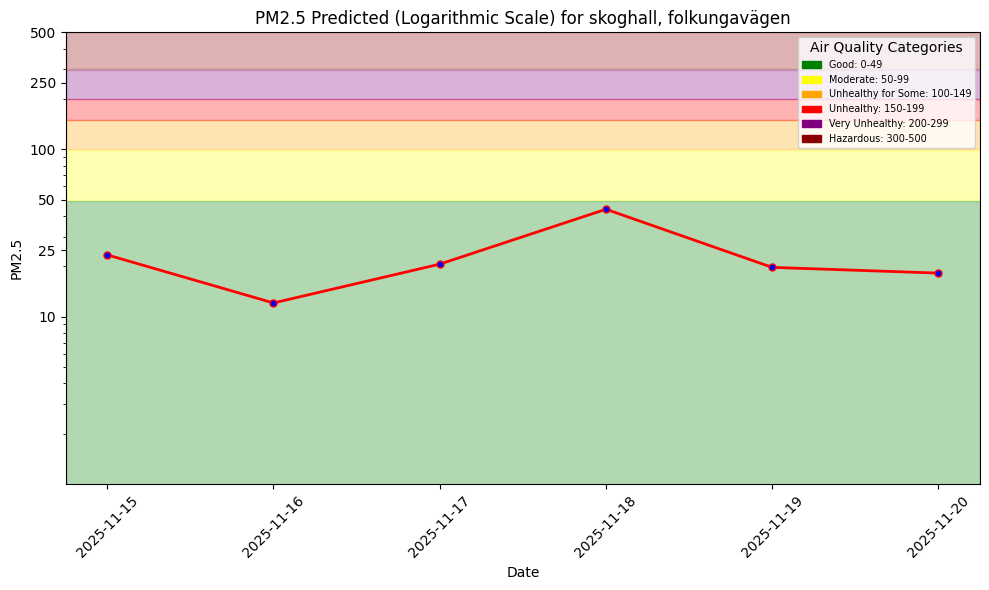

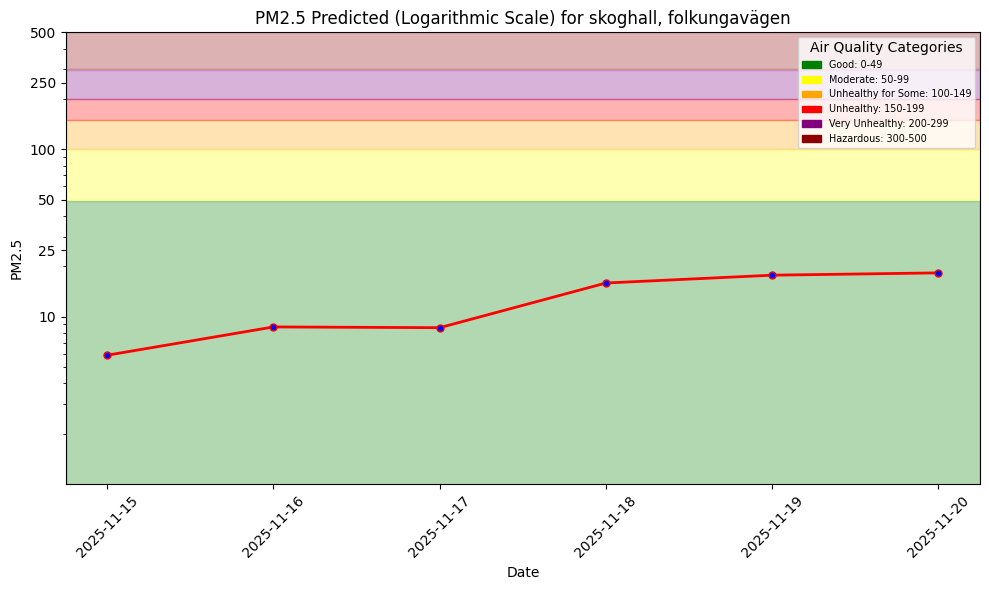

Uploading: 0.000%|          | 0/48852 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/44942 elapsed<00:00 remaining<?

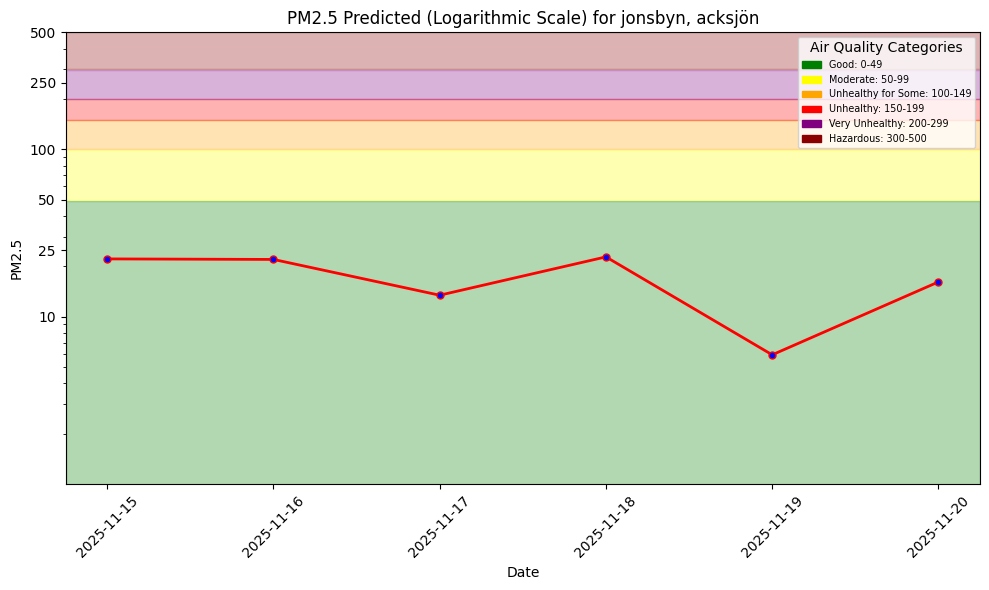

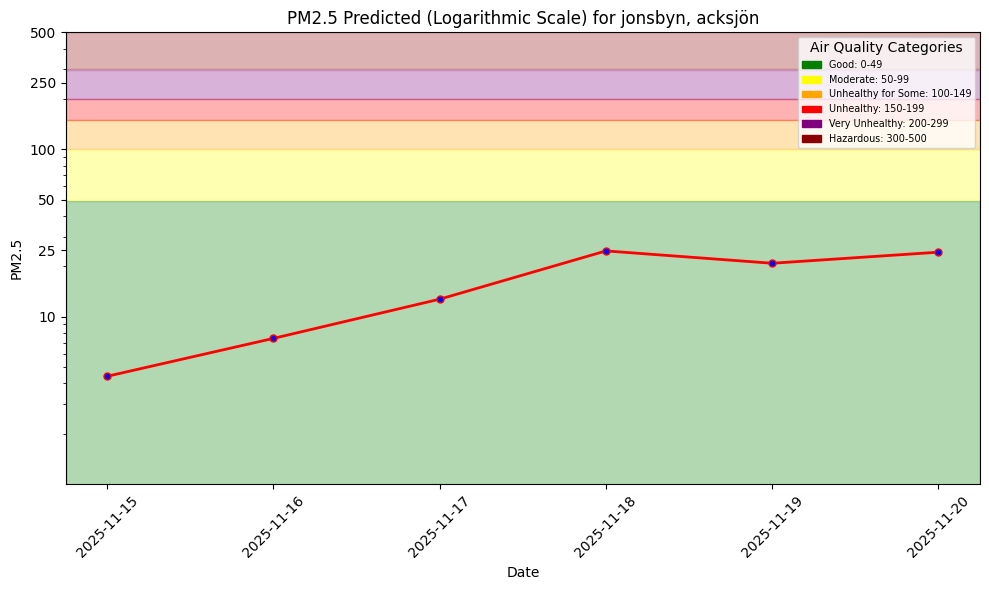

Uploading: 0.000%|          | 0/48454 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/46042 elapsed<00:00 remaining<?

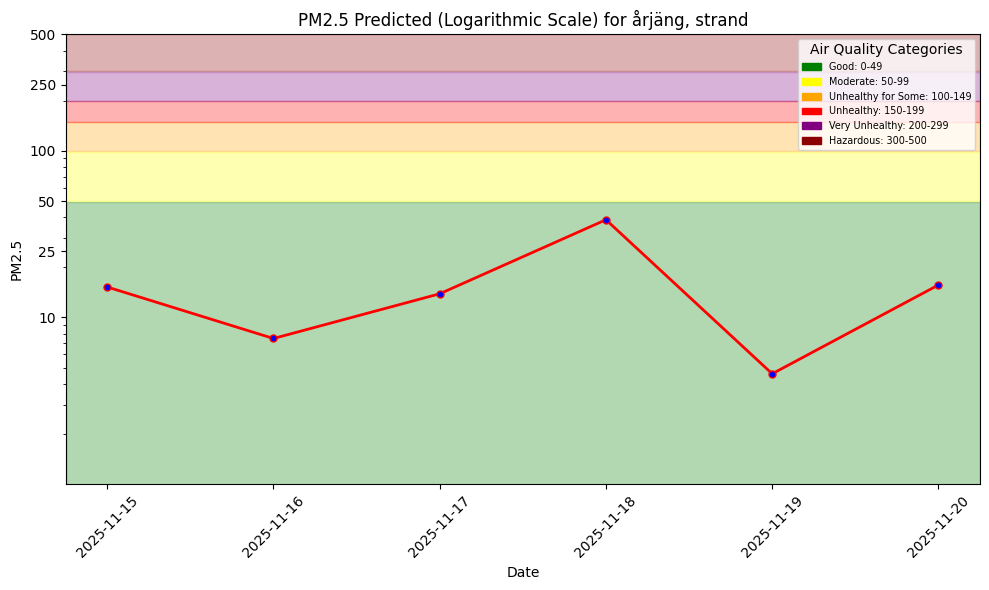

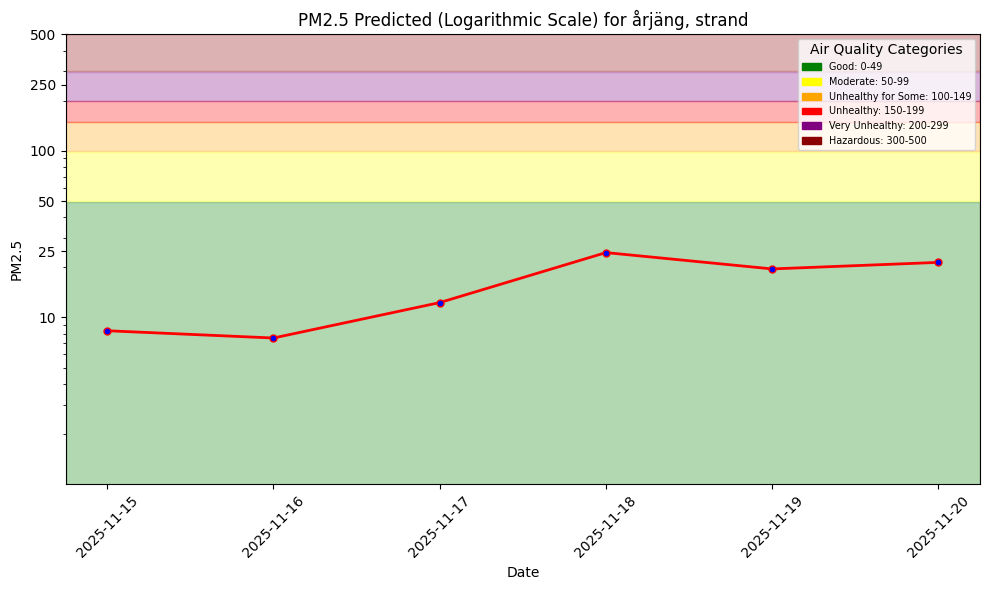

Uploading: 0.000%|          | 0/52376 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/44746 elapsed<00:00 remaining<?

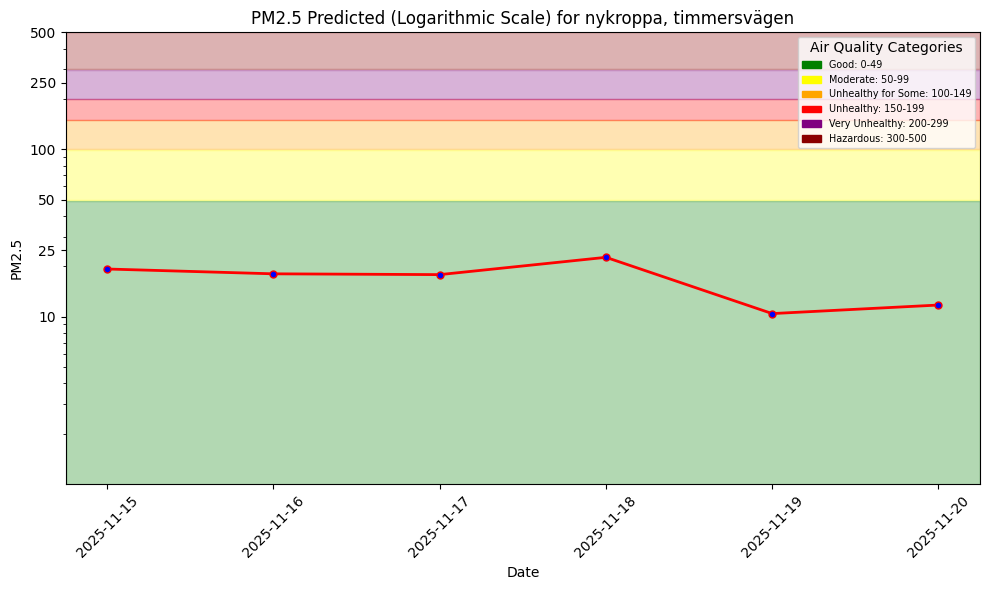

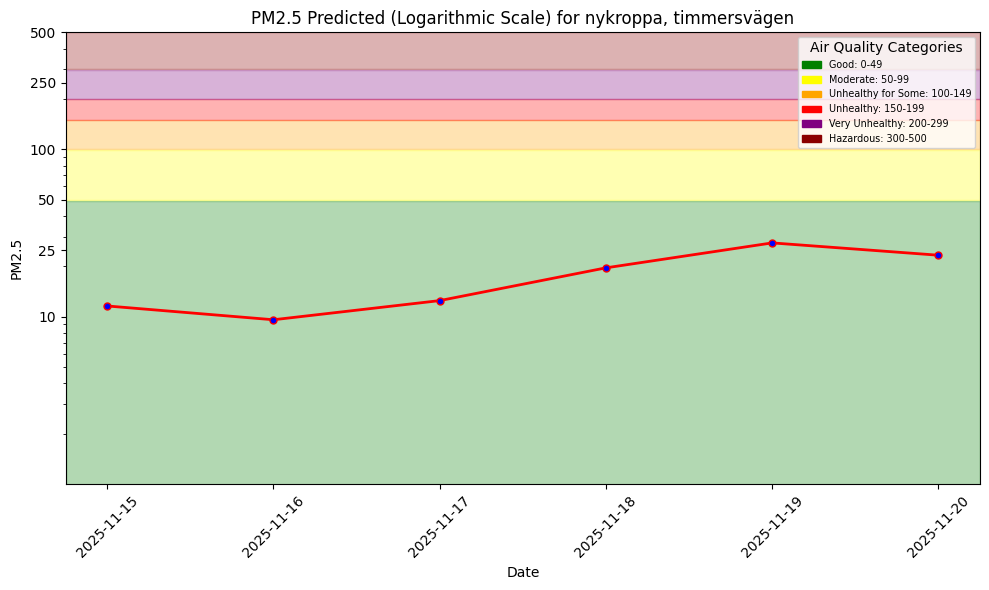

Uploading: 0.000%|          | 0/45460 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/45565 elapsed<00:00 remaining<?

In [16]:
for location in sensors_data:
    city = location['city']
    street = location['street']
    base_city_dir = f"{base_images_dir}/{city}"
    lagged_city_dir = f"{lagged_images_dir}/{city}"
    if not os.path.exists(base_city_dir):
        os.mkdir(base_city_dir)
    if not os.path.exists(lagged_city_dir):
        os.mkdir(lagged_city_dir)
    base_file_path = f"{base_city_dir}/pm25_forcast.png"
    lagged_file_path = f"{lagged_city_dir}/pm25_forcast.png"
    base_plt = util.plot_air_quality_forecast(city, street, air_quality_forecast_base[air_quality_forecast_base['city'] == city], base_file_path)
    lagged_plt = util.plot_air_quality_forecast(city, street, air_quality_forecast_lagged[air_quality_forecast_lagged['city'] == city], lagged_file_path)
    base_plt.show()
    lagged_plt.show()
    dataset_api.upload(base_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(lagged_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

In [17]:
monitor_fg_base = fs.get_or_create_feature_group(
    name='aq_predictions_base',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','country','days_before_forecast_day'],
    event_time="date"
)

monitor_fg_lagged = fs.get_or_create_feature_group(
    name='aq_predictions_lagged',
    description='Air Quality prediction monitoring (lagged)',
    version=1,
    primary_key=['city','street','country','days_before_forecast_day'],
    event_time="date"
)

In [18]:
monitor_fg_base.insert(air_quality_forecast_base)
monitor_fg_lagged.insert(air_quality_forecast_lagged, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 24/24 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_base_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272014/jobs/named/aq_predictions_base_1_offline_fg_materialization/executions


Uploading Dataframe: 100.00% |██████████| Rows 24/24 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_lagged_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272014/jobs/named/aq_predictions_lagged_1_offline_fg_materialization/executions
2025-11-14 17:43:28,553 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-14 17:43:31,759 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-14 17:45:17,938 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-14 17:45:18,094 INFO: Waiting for log aggregation to finish.
2025-11-14 17:45:40,157 INFO: Execution finished successfully.


(Job('aq_predictions_lagged_1_offline_fg_materialization', 'SPARK'), None)

In [19]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_base = monitor_fg_base.filter(monitor_fg_base.days_before_forecast_day == 1).read()
monitoring_lagged = monitor_fg_lagged.filter(monitor_fg_lagged.days_before_forecast_day == 1).read()

air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.64s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.38s) 


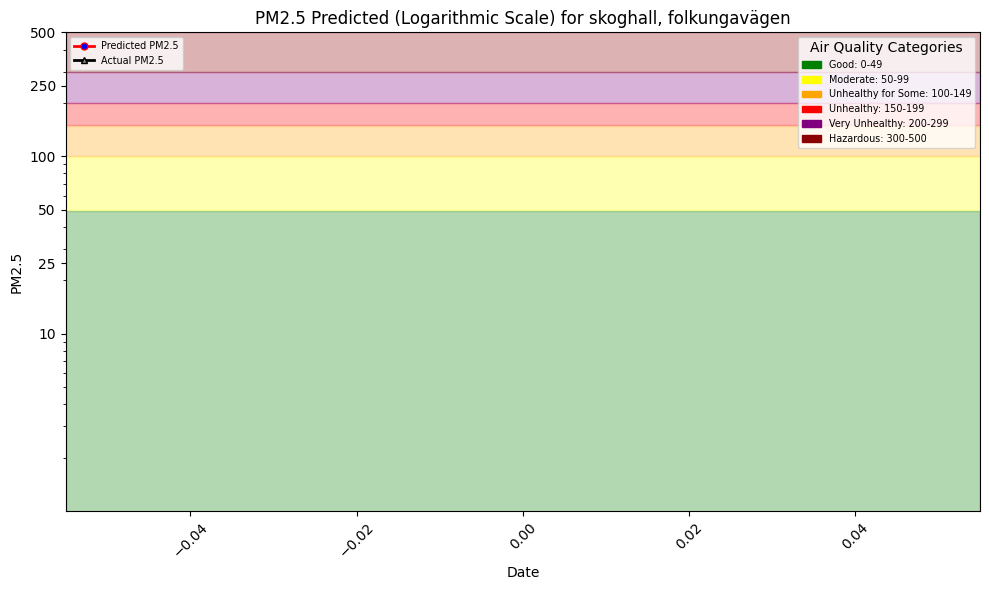

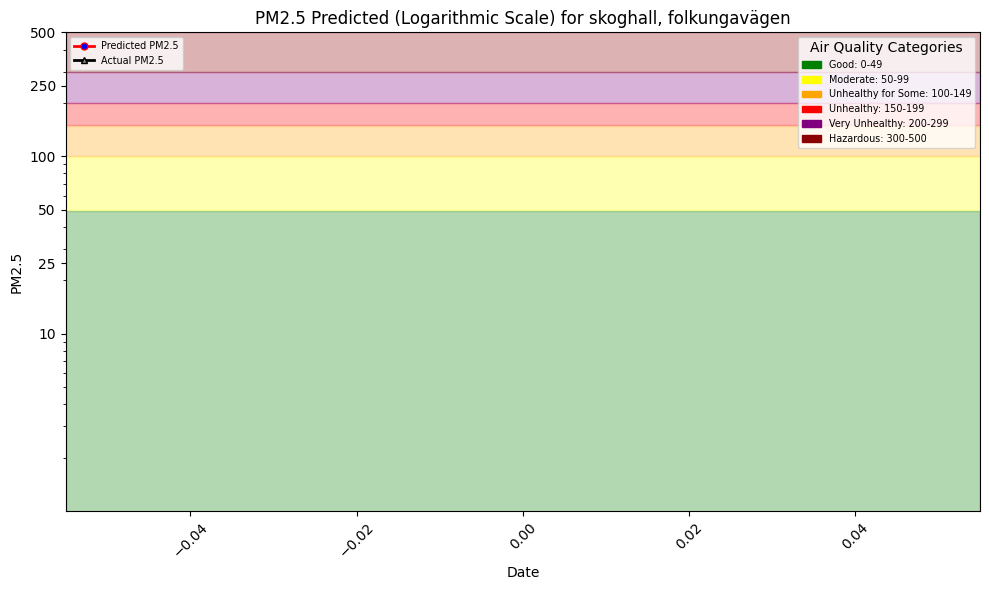

Uploading: 0.000%|          | 0/40812 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/40812 elapsed<00:00 remaining<?

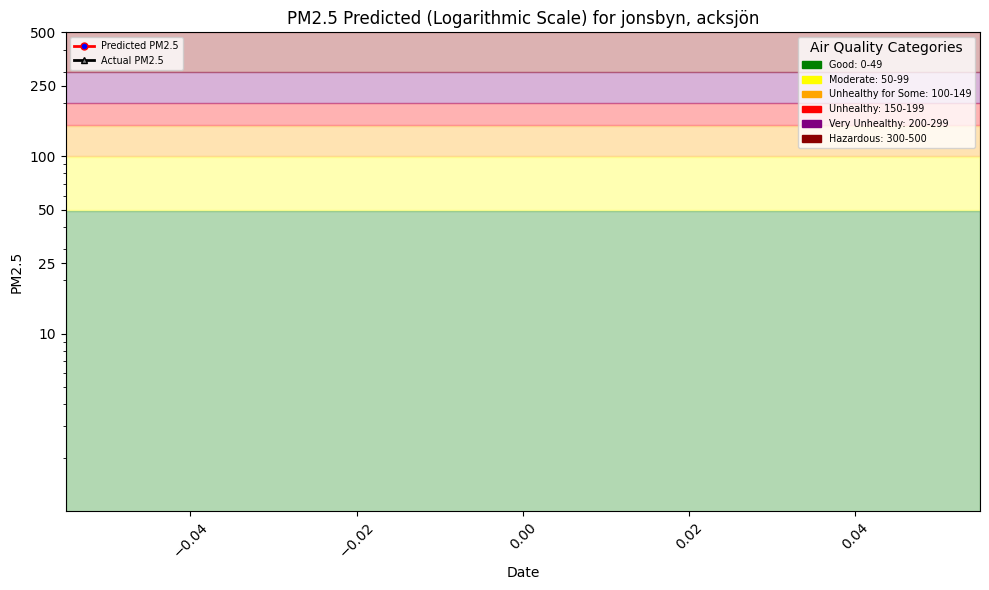

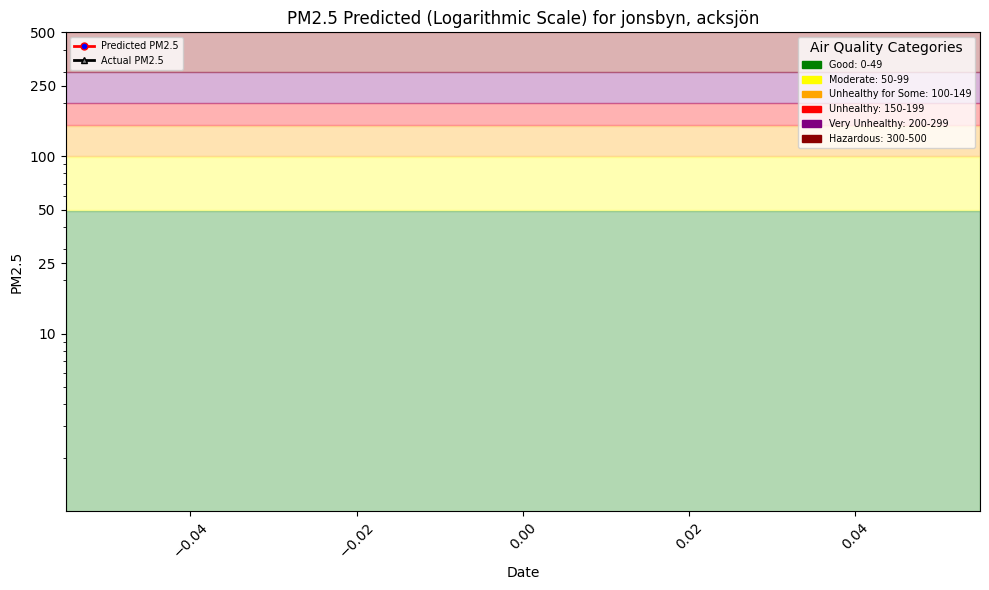

Uploading: 0.000%|          | 0/40000 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/40000 elapsed<00:00 remaining<?

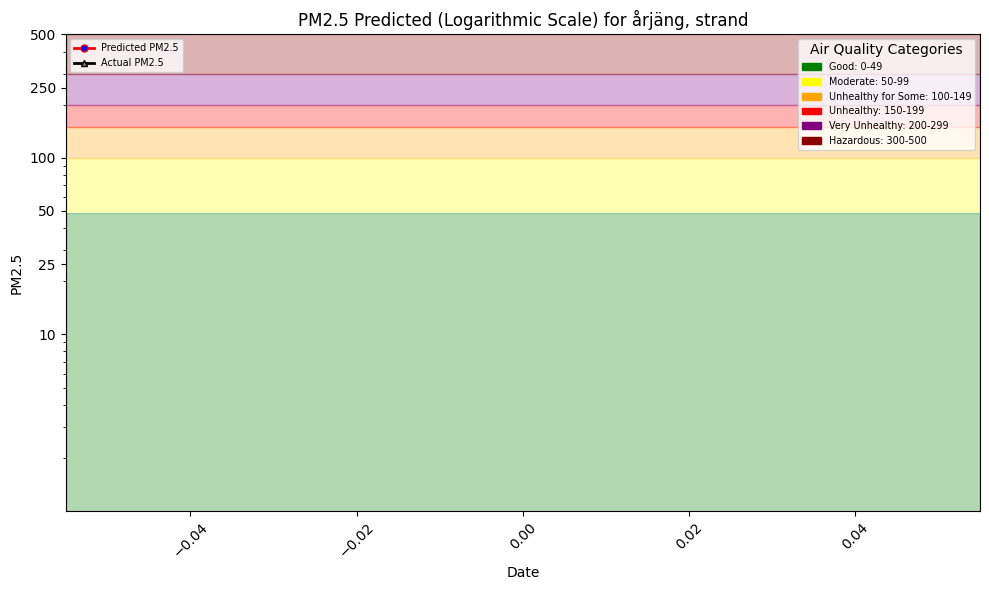

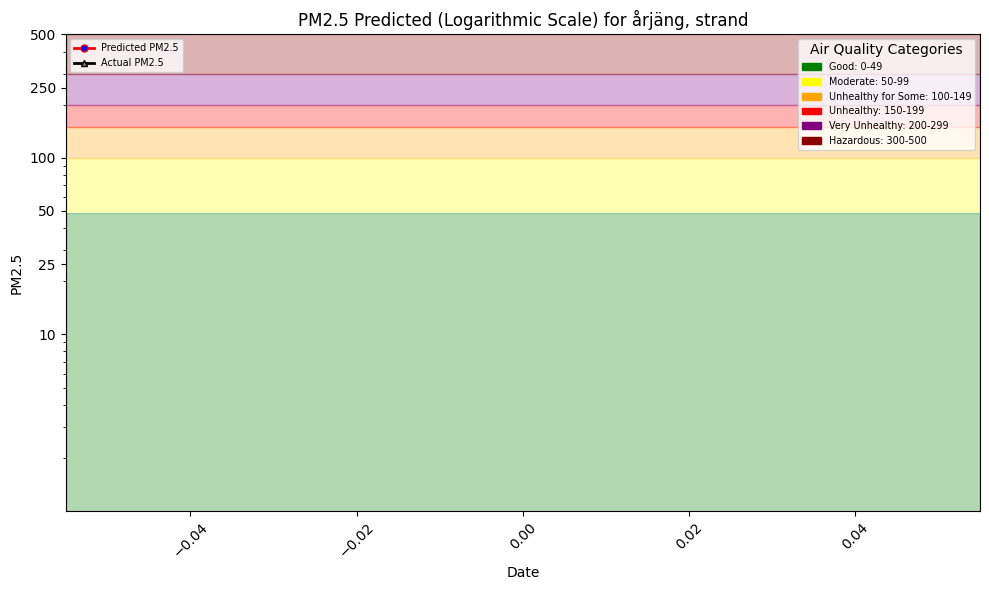

Uploading: 0.000%|          | 0/39424 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/39424 elapsed<00:00 remaining<?

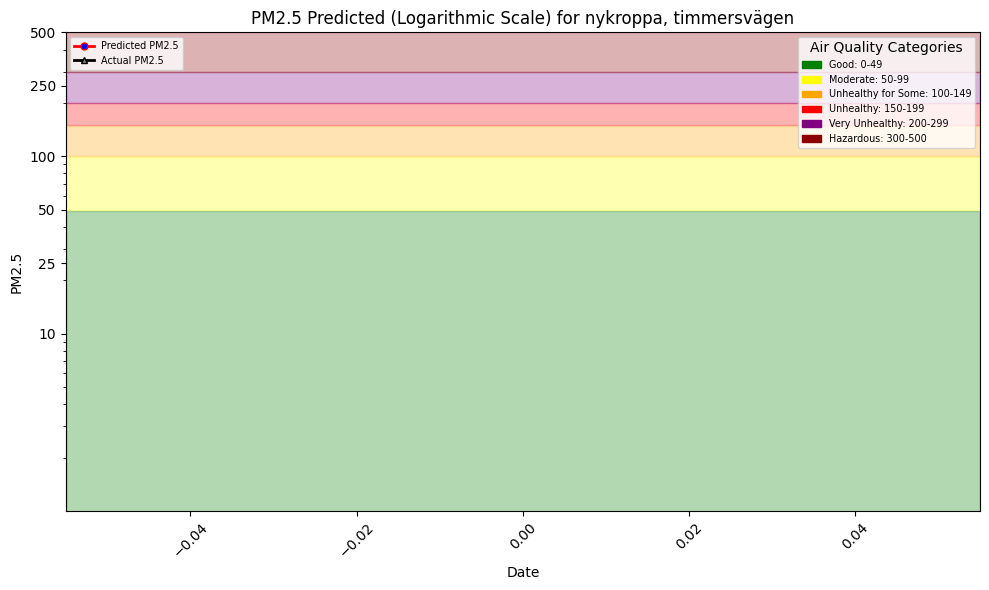

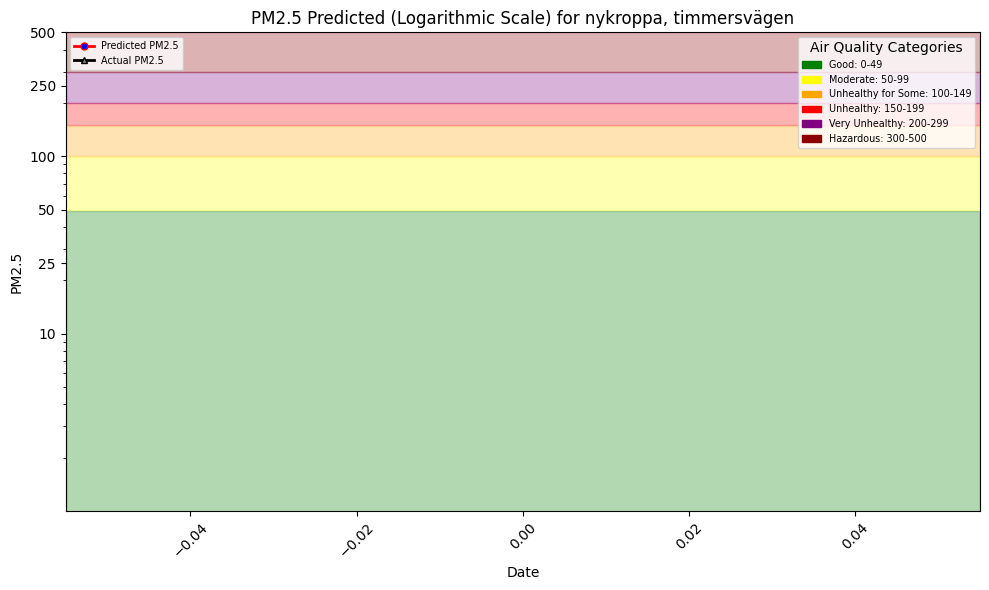

Uploading: 0.000%|          | 0/41008 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/41008 elapsed<00:00 remaining<?

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272014/settings/fb/path/Resources/airquality


In [21]:
preds_base =  monitoring_base[['date', 'predicted_pm25']]
preds_lagged =  monitoring_lagged[['date', 'predicted_pm25']]

hindcast_base = pd.merge(preds_base, air_quality_df, on="date")
hindcast_base = hindcast_base.sort_values(by=['date'])

hindcast_lagged = pd.merge(preds_lagged, air_quality_df, on="date")
hindcast_lagged = hindcast_lagged.sort_values(by=['date'])


# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
for location in sensors_data:
    city = location['city']
    street = location['street']
    hindcast_location_base = hindcast_base[hindcast_base['city'] == city]
    hindcast_location_lagged = hindcast_lagged[hindcast_lagged['city'] == city]
    base_hindcast_path = f"{base_city_dir}/pm25_hindcast.png"
    lagged_hindcast_path = f"{lagged_city_dir}/pm25_hindcast.png"
    base_plt = util.plot_air_quality_forecast(city, street, hindcast_location_base, base_hindcast_path, hindcast=True)
    lagged_plt = util.plot_air_quality_forecast(city, street, hindcast_location_lagged, lagged_hindcast_path, hindcast=True)
    base_plt.show()
    lagged_plt.show()
    dataset_api.upload(base_hindcast_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(lagged_hindcast_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")